In [6]:
#run to start
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import os
import pandas as pd
import numpy as np
from nilearn import image, maskers, plotting, datasets
from nilearn.maskers import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
from nilearn.glm.first_level import compute_regressor
import nibabel as nib
import sys
import time
import itertools 
import warnings


import pdb
import ptoc_params as params

from plotnine import *
#from plotnine import ggplot, aes, geom_point

#hide warnings
import warnings
warnings.filterwarnings('ignore')

#load additional libraries
from nilearn import image, plotting, input_data, glm
from nilearn.input_data import NiftiMasker
import nibabel as nib
import statsmodels.api as sm
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
from nilearn.glm.first_level import compute_regressor ##?????

data_dir = params.data_dir
results_dir = params.results_dir
fig_dir = params.fig_dir
raw_dir = params.raw_dir
sub_info = params.sub_info
task_info = params.task_info

suf = params.suf
#mni = load_mni152_brain_mask()

'''exp info'''
#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
#subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()


##Just controls
#subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/GitHub_Repos/ptoc/results'
exp = ''
#rois = ['LO']  # Run for one ROI initially
#rois = ['LO', 'PFS', 'pIPS','aIPS', 'V1']
control_tasks = ['loc']
file_suf = ''

'''scan params'''
tr = 2 #ptoc_params
vols = 184 #ptoc_params

whole_brain_mask = load_mni152_brain_mask()
mni = load_mni152_template()
brain_masker = NiftiMasker(whole_brain_mask, smoothing_fwhm=0, standardize=True)

In [ ]:
#8/7/24 at 1:30 pm reviewed and confirmed
# 8/6/24 at 10:30 pm Extract_roi_coords
# it runs well and looks good but some of the coordinate are too similar i.e. identical for different runs, this wasn't a problem and confirmed in the below cell. 


import os
import pandas as pd
import numpy as np
from nilearn import image, plotting
import matplotlib.pyplot as plt
import itertools

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
mni_parcel_dir = f'{curr_dir}/roiParcels'

def extract_roi_coords():
    parcels = ['pIPS', 'LO']
    sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
    subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    #subs = ['sub-025']
    
    runs = [1, 2, 3]
    run_combos = list(itertools.combinations(runs, 2))

    # Load MNI152 template for visualization
    mni_template = image.load_img('/opt/fsl/6.0.3/data/standard/MNI152_T1_2mm_brain.nii.gz')

    for ss in subs:
        print(f'Processing subject: {ss}')
        sub_dir = f'{study_dir}/{ss}/ses-01'
        roi_dir = f'{sub_dir}/derivatives/rois'
        os.makedirs(f'{roi_dir}/spheres', exist_ok=True)
        exp_dir = f'{sub_dir}/derivatives/fsl'
        roi_coords = pd.DataFrame(columns=['run_combo', 'roi', 'x', 'y', 'z'])

        for rc in run_combos:
            print(f"Run combination: {rc}")
            all_runs = []
            for rn in rc:
                curr_run_path = f'/lab_data/behrmannlab/vlad/hemispace/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/stats/zstat3_mni.nii.gz'
                if os.path.exists(curr_run_path):
                    curr_run = image.load_img(curr_run_path)
                    all_runs.append(curr_run)
                else:
                    print(f'File does not exist: {curr_run_path}')

            if len(all_runs) != 2:
                print(f"Skipping combination {rc} due to missing data")
                continue

            mean_zstat = image.mean_img(all_runs)

            for pr in parcels:
                roi_path = f'{mni_parcel_dir}/{pr}.nii.gz'
                if os.path.exists(roi_path):
                    roi = image.load_img(roi_path)
                    
                    # Find peak voxel within ROI
                    masked_data = image.math_img('img1 * img2', img1=mean_zstat, img2=roi).get_fdata()
                    peak_idx = np.unravel_index(np.argmax(masked_data), masked_data.shape)
                    peak_coords = image.coord_transform(*peak_idx, mean_zstat.affine)
                    
                    roi_coords = pd.concat([roi_coords, pd.DataFrame({
                        'run_combo': [f'{rc[0]}{rc[1]}'],
                        'roi': [pr],
                        'x': [peak_coords[0]],
                        'y': [peak_coords[1]],
                        'z': [peak_coords[2]]
                    })], ignore_index=True)

                    # Visualize ROI and peak voxel on MNI template
                    display = plotting.plot_roi(roi, bg_img=mni_template, 
                                                title=f'{ss} - {pr} - Runs {rc[0]}{rc[1]}')
                    display.add_markers([peak_coords], marker_color='r', marker_size=100)
                    #plt.savefig(f'{roi_dir}/{ss}_{pr}_runs{rc[0]}{rc[1]}_peak_mni.png')
                    plt.close()

                    print(f"ROI: {pr}, Peak coordinates: {peak_coords}")
                else:
                    print(f'ROI file does not exist: {roi_path}')

        roi_coords.to_csv(f'{roi_dir}/spheres/sphere_coords.csv', index=False)
        print(f"ROI coordinates saved to {roi_dir}/spheres/sphere_coords.csv")

if __name__ == "__main__":
    extract_roi_coords()
    print("ROI coordinate extraction completed.")

In [ ]:
#8/7/24 1 pm confirming the extraction of the coordinates process - it works well
import os
import pandas as pd
import numpy as np
from nilearn import image, plotting
import matplotlib.pyplot as plt
import itertools

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
mni_parcel_dir = f'{curr_dir}/roiParcels'

def is_unique(coords, existing_coords, tolerance=1.0):
    for existing in existing_coords:
        if np.all(np.abs(np.array(coords) - np.array(existing)) < tolerance):
            return False
    return True

def extract_roi_coords():
    parcels = ['pIPS', 'LO']
    sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
    subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    #subs = ['sub-025']
    runs = [1, 2, 3]
    run_combos = list(itertools.combinations(runs, 2))

    # Load MNI152 template for visualization
    mni_template = image.load_img('/opt/fsl/6.0.3/data/standard/MNI152_T1_2mm_brain.nii.gz')

    for ss in subs:
        print(f'Processing subject: {ss}')
        sub_dir = f'{study_dir}/{ss}/ses-01'
        roi_dir = f'{sub_dir}/derivatives/rois'
        os.makedirs(f'{roi_dir}/spheres', exist_ok=True)
        exp_dir = f'{sub_dir}/derivatives/fsl'

        roi_coords = pd.DataFrame(columns=['run_combo', 'roi', 'x', 'y', 'z', 'peak_value'])

        for rc in run_combos:
            print(f"Run combination: {rc}")
            all_runs = []
            for rn in rc:
                curr_run_path = f'/lab_data/behrmannlab/vlad/hemispace/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/stats/zstat3_mni.nii.gz'
                if os.path.exists(curr_run_path):
                    curr_run = image.load_img(curr_run_path)
                    all_runs.append(curr_run)
                    print(f"Run {rn} stats: mean={np.mean(curr_run.get_fdata()):.4f}, max={np.max(curr_run.get_fdata()):.4f}")
                else:
                    print(f'File does not exist: {curr_run_path}')

            if len(all_runs) != 2:
                print(f"Skipping combination {rc} due to missing data")
                continue

            mean_zstat = image.mean_img(all_runs)

            for pr in parcels:
                roi_path = f'{mni_parcel_dir}/{pr}.nii.gz'
                if os.path.exists(roi_path):
                    roi = image.load_img(roi_path)
                    
                    # Find peak voxel within ROI
                    masked_data = image.math_img('img1 * img2', img1=mean_zstat, img2=roi).get_fdata()
                    
                    print(f"ROI: {pr}")
                    print(f"Number of voxels in ROI: {np.sum(masked_data != 0)}")
                    print(f"Max value in masked data: {np.max(masked_data)}")
                    print(f"Number of voxels with max value: {np.sum(masked_data == np.max(masked_data))}")
                    
                    flat_indices = np.argsort(masked_data.ravel())[::-1][:5]
                    peak_indices = np.unravel_index(flat_indices, masked_data.shape)
                    print("Top 5 peak voxels:")
                    for i in range(5):
                        peak_coords = image.coord_transform(peak_indices[0][i], peak_indices[1][i], peak_indices[2][i], mean_zstat.affine)
                        peak_value = masked_data[peak_indices[0][i], peak_indices[1][i], peak_indices[2][i]]
                        print(f"  Voxel {i+1}: coordinates {peak_coords}, value {peak_value}")
                    
                    peak_idx = np.unravel_index(np.argmax(masked_data), masked_data.shape)
                    print(f"Selected peak voxel indices: {peak_idx}")
                    
                    peak_coords = image.coord_transform(*peak_idx, mean_zstat.affine)
                    print(f"Peak coordinates before rounding: {peak_coords}")
                    
                    # Round coordinates
                    peak_coords = tuple(round(coord, 2) for coord in peak_coords)
                    peak_value = masked_data[peak_idx]
                    
                    # Check for uniqueness
                    existing_coords = roi_coords[roi_coords['roi'] == pr][['x', 'y', 'z']].values.tolist()
                    if is_unique(peak_coords, existing_coords):
                        roi_coords = pd.concat([roi_coords, pd.DataFrame({
                            'run_combo': [f'{rc[0]}{rc[1]}'],
                            'roi': [pr],
                            'x': [peak_coords[0]],
                            'y': [peak_coords[1]],
                            'z': [peak_coords[2]],
                            'peak_value': [peak_value]
                        })], ignore_index=True)
                    else:
                        print(f"Warning: Similar coordinates already exist for {pr}")

                    # Visualize ROI and peak voxel on MNI template
                    display = plotting.plot_roi(roi, bg_img=mni_template,
                                                title=f'{ss} - {pr} - Runs {rc[0]}{rc[1]}')
                    display.add_markers([peak_coords], marker_color='r', marker_size=100)
                    plt.savefig(f'{roi_dir}/{ss}_{pr}_runs{rc[0]}{rc[1]}_peak_mni.png')
                    plt.close()

                    print(f"ROI: {pr}, Peak coordinates: {peak_coords}, Peak value: {peak_value}")
                else:
                    print(f'ROI file does not exist: {roi_path}')

        print(f"\nExtracted ROI coordinates for subject {ss}:")
        print(roi_coords.to_string(index=False))
        print("\n")

if __name__ == "__main__":
    extract_roi_coords()
    print("ROI coordinate extraction completed.")

In [ ]:
#8.7.24 1 pm, plots heat map of averaged and raw individual run's ROIs

import os
import pandas as pd
import numpy as np
from nilearn import image, plotting
import matplotlib.pyplot as plt
import itertools

# Set up directories and parameters
study = 'hemispace'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
mni_parcel_dir = f'{curr_dir}/roiParcels'

def visualize_roi_activation_raw():
    parcels = ['pIPS', 'LO']
    sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
    #subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    subs = ['sub-025', 'sub-057', 'sub-059'] # Update this list as needed
    runs = [1, 2, 3]
    run_combos = list(itertools.combinations(runs, 2))

    # Load MNI152 template for visualization
    mni_template = image.load_img('/opt/fsl/6.0.3/data/standard/MNI152_T1_2mm_brain.nii.gz')

    for ss in subs:
        print(f'Visualizing activation for subject: {ss}')
        sub_dir = f'{study_dir}/{ss}/ses-01'
        roi_dir = f'{sub_dir}/derivatives/rois'
        exp_dir = f'{sub_dir}/derivatives/fsl'

        for rc in run_combos:
            print(f"Run combination: {rc}")
            all_runs = []
            for rn in rc:
                curr_run_path = f'{exp_dir}/loc/run-0{rn}/1stLevel.feat/stats/zstat3_mni.nii.gz'
                if os.path.exists(curr_run_path):
                    curr_run = image.load_img(curr_run_path)
                    all_runs.append(curr_run)
                    # Print summary statistics
                    data = curr_run.get_fdata()
                    print(f"Run {rn} stats: mean={np.mean(data):.4f}, max={np.max(data):.4f}, min={np.min(data):.4f}, std={np.std(data):.4f}")
                else:
                    print(f'File does not exist: {curr_run_path}')
            
            if len(all_runs) != 2:
                print(f"Skipping combination {rc} due to missing data")
                continue
            
            # Manual averaging
            mean_data = np.mean([run.get_fdata() for run in all_runs], axis=0)
            mean_zstat = image.new_img_like(all_runs[0], mean_data)
            
            # Print summary statistics of the averaged data
            print(f"Averaged data stats: mean={np.mean(mean_data):.4f}, max={np.max(mean_data):.4f}, min={np.min(mean_data):.4f}, std={np.std(mean_data):.4f}")

            for pr in parcels:
                roi_path = f'{mni_parcel_dir}/{pr}.nii.gz'
                if os.path.exists(roi_path):
                    roi = image.load_img(roi_path)
                    # Create a masked version of the mean_zstat image
                    masked_zstat = image.math_img('img1 * img2', img1=mean_zstat, img2=roi)

                    # Visualize the activation within the ROI
                    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
                    fig.suptitle(f'{ss} - {pr} - Runs {rc[0]}{rc[1]} Activation')

                    # Sagittal view
                    plotting.plot_stat_map(masked_zstat, bg_img=mni_template,
                                           display_mode='x', cut_coords=1,
                                           threshold=0, colorbar=True, axes=ax1)
                    ax1.set_title('Sagittal')

                    # Coronal view
                    plotting.plot_stat_map(masked_zstat, bg_img=mni_template,
                                           display_mode='y', cut_coords=1,
                                           threshold=0, colorbar=True, axes=ax2)
                    ax2.set_title('Coronal')

                    # Axial view
                    plotting.plot_stat_map(masked_zstat, bg_img=mni_template,
                                           display_mode='z', cut_coords=1,
                                           threshold=0, colorbar=True, axes=ax3)
                    ax3.set_title('Axial')

                    plt.tight_layout()
                    #plt.savefig(f'{roi_dir}/{ss}_{pr}_runs{rc[0]}{rc[1]}_activation.png')
                    #plt.close()
                    print(f"Activation map saved for ROI: {pr}")
                else:
                    print(f'ROI file does not exist: {roi_path}')

    print("ROI activation visualization completed.")

def visualize_roi_activation_combos():
    parcels = ['pIPS', 'LO']
    sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
    #subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    subs = ['sub-025', 'sub-057', 'sub-059']  # Update this list as needed
    
    runs = [1, 2, 3]
    run_combos = list(itertools.combinations(runs, 2))

    # Load MNI152 template for visualization
    mni_template = image.load_img('/opt/fsl/6.0.3/data/standard/MNI152_T1_2mm_brain.nii.gz')

    for ss in subs:
        print(f'Visualizing activation for subject: {ss}')
        sub_dir = f'{study_dir}/{ss}/ses-01'
        roi_dir = f'{sub_dir}/derivatives/rois'
        exp_dir = f'{sub_dir}/derivatives/fsl'

        for rc in run_combos:
            print(f"Run combination: {rc}")
            all_runs = []
            for rn in rc:
                curr_run_path = f'{exp_dir}/loc/run-0{rn}/1stLevel.feat/stats/zstat3_mni.nii.gz'
                if os.path.exists(curr_run_path):
                    curr_run = image.load_img(curr_run_path)
                    all_runs.append(curr_run)
                else:
                    print(f'File does not exist: {curr_run_path}')

            if len(all_runs) != 2:
                print(f"Skipping combination {rc} due to missing data")
                continue

            mean_zstat = image.mean_img(all_runs)

            for pr in parcels:
                roi_path = f'{mni_parcel_dir}/{pr}.nii.gz'
                if os.path.exists(roi_path):
                    roi = image.load_img(roi_path)
                    
                    # Create a masked version of the mean_zstat image
                    masked_zstat = image.math_img('img1 * img2', img1=mean_zstat, img2=roi)
                    
                    # Visualize the activation within the ROI
                    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
                    fig.suptitle(f'{ss} - {pr} - Runs {rc[0]}{rc[1]} Activation')
                    
                    # Sagittal view
                    plotting.plot_stat_map(masked_zstat, bg_img=mni_template, 
                                        display_mode='x', cut_coords=1, 
                                        threshold=0, colorbar=True, axes=ax1)
                    ax1.set_title('Sagittal')

                    # Coronal view
                    plotting.plot_stat_map(masked_zstat, bg_img=mni_template, 
                                        display_mode='y', cut_coords=1, 
                                        threshold=0, colorbar=True, axes=ax2)
                    ax2.set_title('Coronal')

                    # Axial view
                    plotting.plot_stat_map(masked_zstat, bg_img=mni_template, 
                                        display_mode='z', cut_coords=1, 
                                        threshold=0, colorbar=True, axes=ax3)
                    ax3.set_title('Axial')
                    
                    plt.tight_layout()
                    #plt.savefig(f'{roi_dir}/{ss}_{pr}_runs{rc[0]}{rc[1]}_activation.png')
                    #plt.close()

                    print(f"Activation map saved for ROI: {pr}")
                else:
                    print(f'ROI file does not exist: {roi_path}')

    print("ROI activation visualization completed.")

if __name__ == "__main__":
    #visualize_roi_activation_combos()
    #visualize_roi_activation_raw()

Psy data shape: (184, 1)


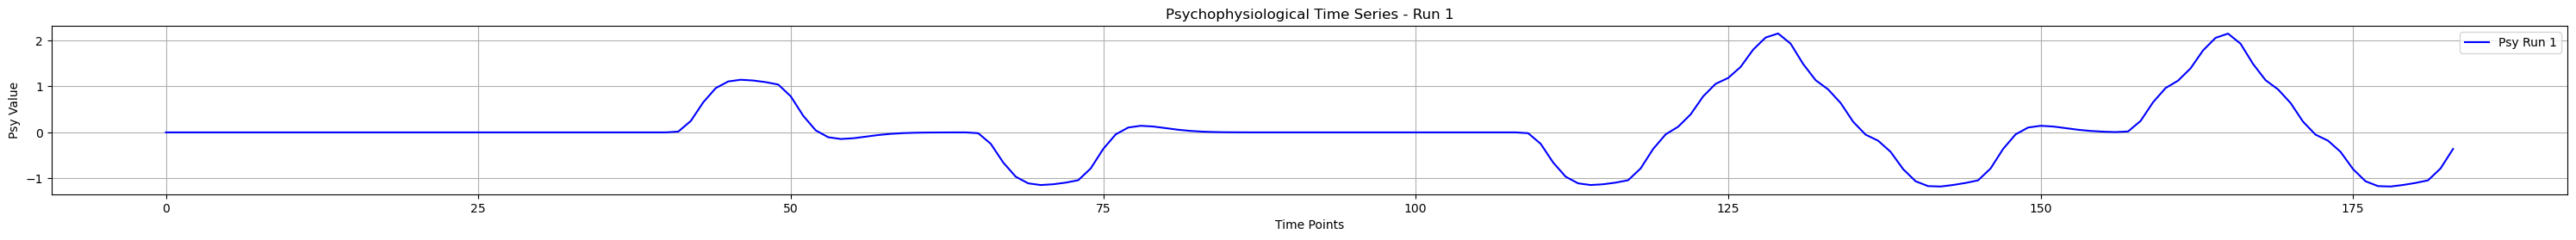

Extracted phys data shape: (184, 1) for ROI LO with coordinates [44.0871464314634, -41.95252311, -3.091983301]
Extracted phys data shape: (184, 1) for ROI LO with coordinates [44.0871464314634, -41.95252311, -3.091983301]


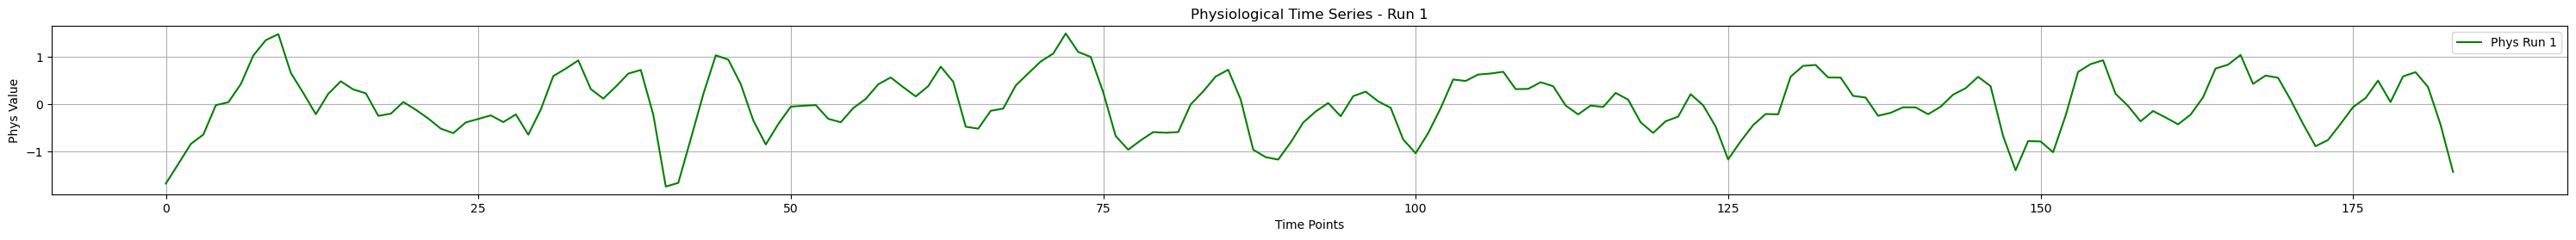

In [11]:
#print psy and phys correctly 

# Define constants
ss = '064'  # Subject ID
tsk = 'loc'  # Task name
tr = 2  # Repetition time
vols = 184  # Number of volumes
rc = [1, 2]  # Run combinations (unchangeable)
roi_name = 'LO'  # ROI name
exp = 'loc'  # Experiment name
raw_dir = params.raw_dir  # Path to raw data
n_time_points = 184  # Number of time points per run
n_runs = 1  # Number of runs (adjust as needed)

# Directories
sub_dir = f'{study_dir}/sub-{ss}/ses-01/'
roi_dir = f'{sub_dir}/derivatives/rois'
temp_dir = f'{raw_dir}/sub-{ss}/ses-01'
cov_dir = f'{temp_dir}/covs'

# Load and print psy data
psy = make_psy_cov(rc, ss)  # Load psy covariates
print(f'Psy data shape: {psy.shape}')

# Plot psy data
plt.figure(figsize=(30, 5))
for run in range(n_runs):
    plt.subplot(2, 1, run + 1)
    plt.plot(np.arange(n_time_points), psy[:, run], label=f'Psy Run {run + 1}', color='blue')
    plt.xlabel('Time Points')
    plt.ylabel('Psy Value')
    plt.title(f'Psychophysiological Time Series - Run {run + 1}')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# Load ROI coordinates and process phys data
roi_coords = pd.read_csv(f'{roi_dir}/spheres/sphere_coords.csv')
curr_coords = roi_coords[(roi_coords['task'] == tsk) & (roi_coords['roi'] == roi_name)]

for rn in rc:
    run_path = f'{temp_dir}/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/filtered_func_data_reg.nii.gz'
    if os.path.exists(run_path):
        curr_run = image.load_img(run_path)  # Load image data
        curr_run = image.clean_img(curr_run, standardize=True)
        if not curr_coords.empty:
            coords = curr_coords[['x', 'y', 'z']].values[0].tolist()
            phys = extract_roi_sphere(curr_run, coords)
            print(f'Extracted phys data shape: {phys.shape} for ROI {roi_name} with coordinates {coords}')
        else:
            print(f'No coordinates found for ROI {roi_name} and task {tsk}')
    else:
        print(f"File {run_path} does not exist.")

# Plot phys data
plt.figure(figsize=(30, 5))
for run in range(n_runs):
    plt.subplot(2, 1, run + 1)
    plt.plot(np.arange(n_time_points), phys[:, run], label=f'Phys Run {run + 1}', color='green')
    plt.xlabel('Time Points')
    plt.ylabel('Phys Value')
    plt.title(f'Physiological Time Series - Run {run + 1}')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#fc_ppi_wrong_ROIS
import os
import pandas as pd
import numpy as np
from nilearn import image, input_data
from nilearn.maskers import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
from nilearn.glm.first_level import compute_regressor
import nibabel as nib
import sys

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/GitHub_Repos/ptoc/results'
raw_dir = params.raw_dir

#sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
#subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
subs = ['sub-107', 'sub-064', 'sub-025']
rois = ['V1','aIPS','LO']
run_num = 3
runs = list(range(1, run_num + 1))
run_combos = [[rn1, rn2] for rn1 in range(1, run_num + 1) for rn2 in range(rn1 + 1, run_num + 1)]

whole_brain_mask = load_mni152_brain_mask()
brain_masker = NiftiMasker(whole_brain_mask, smoothing_fwhm=0, standardize=True)

def extract_roi_sphere(img, coords):
    roi_masker = input_data.NiftiSpheresMasker([tuple(coords)], radius=6)
    seed_time_series = roi_masker.fit_transform(img)
    phys = np.mean(seed_time_series, axis=1).reshape(-1, 1)
    return phys

def make_psy_cov(runs, ss):
    temp_dir = f'{raw_dir}/{ss}/ses-01'
    cov_dir = f'{temp_dir}/covs'
    vols, tr = 184, 2.0
    times = np.arange(0, vols * tr, tr)
    full_cov = pd.DataFrame(columns=['onset', 'duration', 'value'])

    for rn in runs:
        ss_num = ss.split('-')[1]
        obj_cov_file = f'{cov_dir}/catloc_{ss_num}_run-0{rn}_Object.txt'
        scr_cov_file = f'{cov_dir}/catloc_{ss_num}_run-0{rn}_Scramble.txt'

        if not os.path.exists(obj_cov_file) or not os.path.exists(scr_cov_file):
            print(f'Covariate file not found for run {rn}')
            continue

        obj_cov = pd.read_csv(obj_cov_file, sep='\t', header=None, names=['onset', 'duration', 'value'])
        scr_cov = pd.read_csv(scr_cov_file, sep='\t', header=None, names=['onset', 'duration', 'value'])
        scr_cov['value'] *= -1
        full_cov = pd.concat([full_cov, obj_cov, scr_cov])

    full_cov = full_cov.sort_values(by=['onset']).reset_index(drop=True)
    cov = full_cov.to_numpy()
    valid_onsets = cov[:, 0] < times[-1]
    cov = cov[valid_onsets]

    if cov.shape[0] == 0:
        print('No valid covariate data after filtering. Returning zeros array.')
        return np.zeros((vols, 1))

    psy, _ = compute_regressor(cov.T, 'spm', times)
    return psy

def conduct_analyses():
    for ss in subs:
        print(f"Processing subject: {ss}")
        sub_dir = f'{study_dir}/{ss}/ses-01/'
        roi_dir = f'{sub_dir}derivatives/rois'
        temp_dir = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc'
        
        roi_coords = pd.read_csv(f'{roi_dir}/spheres/sphere_coords.csv')
        
        out_dir = f'{study_dir}/{ss}/ses-01/derivatives'
        os.makedirs(f'{out_dir}/fc', exist_ok=True)
        os.makedirs(f'{out_dir}/fc', exist_ok=True)

        for tsk in ['loc']:
            for rr in rois:
                print(f"Processing ROI: {rr}")
                
                fc_file = f'{out_dir}/fc/{ss}_{rr}_{tsk}_fc.nii.gz'
                ppi_file = f'{out_dir}/fc/{ss}_{rr}_{tsk}_ppi.nii.gz'
                
                do_fc = not os.path.exists(fc_file)
                do_ppi = not os.path.exists(ppi_file)
                
                if not do_fc and not do_ppi:
                    print(f'Both FC and PPI files for {rr} already exist. Skipping...')
                    continue
                
                all_runs_fc = []
                all_runs_ppi = []
                
                for rcn, rc in enumerate(run_combos):
                    curr_coords = roi_coords[(roi_coords['index'] == rcn) & (roi_coords['task'] == tsk) & (roi_coords['roi'] == rr)]
                    coords = curr_coords[['x', 'y', 'z']].values.tolist()[0]
                    
                    filtered_list = [image.clean_img(image.load_img(f'{temp_dir}/run-0{rn}/1stLevel.feat/filtered_func_data_reg.nii.gz'), standardize=True) for rn in rc]
                    img4d = image.concat_imgs(filtered_list)
                    
                    phys = extract_roi_sphere(img4d, coords)
                    
                    # Ensure phys length matches the number of volumes
                    if phys.shape[0] > 184 * len(rc):
                        phys = phys[:184 * len(rc)]
                    
                    brain_time_series = brain_masker.fit_transform(img4d)
                    
                    if do_fc:
                        # FC Analysis
                        correlations = np.dot(brain_time_series.T, phys) / phys.shape[0]
                        correlations = np.arctanh(correlations.ravel())
                        correlation_img = brain_masker.inverse_transform(correlations)
                        all_runs_fc.append(correlation_img)
                    
                    if do_ppi:
                        # PPI Analysis
                        psy = make_psy_cov(rc, ss)  # Generate psy for the current run combination
                        
                        # Ensure psy length matches phys
                        if psy.shape[0] > phys.shape[0]:
                            psy = psy[:phys.shape[0]]
                        elif psy.shape[0] < phys.shape[0]:
                            phys = phys[:psy.shape[0]]
                            brain_time_series = brain_time_series[:psy.shape[0]]
                        
                        ppi_regressor = phys * psy
                        ppi_correlations = np.dot(brain_time_series.T, ppi_regressor) / ppi_regressor.shape[0]
                        ppi_correlations = np.arctanh(ppi_correlations.ravel())
                        ppi_img = brain_masker.inverse_transform(ppi_correlations)
                        all_runs_ppi.append(ppi_img)
                
                if do_fc:
                    mean_fc = image.mean_img(all_runs_fc)
                    nib.save(mean_fc, fc_file)
                    print(f'Saved FC result for {rr}')
                
                if do_ppi:
                    mean_ppi = image.mean_img(all_runs_ppi)
                    nib.save(mean_ppi, ppi_file)
                    print(f'Saved PPI result for {rr}')

# Call the function
conduct_analyses()

In [ ]:
#create Summary
#pause before this section to review output with Vlad

def create_summary():
    """
    extract avg PPI in LO  and PFS
    """
    ventral_rois = ['LO_toolloc']
    #rois = ["PPC_spaceloc", "PPC_distloc", "PPC_toolloc"]
    rois = ["PPC_spaceloc", "APC_spaceloc", "APC_distloc", "APC_toolloc"]
    print(subs)
    #For each ventral ROI
    for lrv in ['l','r']:
        
        for vr in ventral_rois:
            
            summary_df = pd.DataFrame(columns = ['sub'] + ['l' + rr for rr in rois] + ['r' + rr for rr in rois])
            #summary_df = pd.DataFrame(columns = ['sub'] + ['r' + rr for rr in rois])
            ventral = f'{lrv}{vr}'
            print(ventral)
            
            for ss in subs:
                
                sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
                roi_dir = f'{sub_dir}/derivatives/rois'
                
                #if os.path.exists(f'{roi_dir}/{ventral}_peak.nii.gz'):
                ventral_mask = image.load_img(f'{roi_dir}/{ventral}.nii.gz')
                ventral_mask = input_data.NiftiMasker(ventral_mask)
                
                
                roi_mean = []
                roi_mean.append(ss)
                
                #For each dorsal ROI
                for lr in ['l','r']:
                    for rr in rois:
                        
                        roi = f'{lr}{rr}'
                        if os.path.exists(f'{out_dir}/sub-{study}{ss}_{roi}_fc.nii.gz'):
                            ppi_img = image.load_img(f'{out_dir}/sub-{study}{ss}_{roi}_fc.nii.gz')
                            #ppi_img  = image.smooth_img(ppi_img, 6)
                            acts = ventral_mask.fit_transform(ppi_img)

                            
                            roi_mean.append(acts.mean())
                        else:
                            roi_mean.append(np.nan)
            #pdb.set_trace()
                summary_df = summary_df.append(pd.Series(roi_mean, index = summary_df.columns), ignore_index = True)
        #print(ventral)
            summary_df.to_csv(f'{results_dir}/ppi/{ventral}_fc{file_suf}.csv', index=False)
        #summary_df.iloc[:, 1:].mean().plot.bar()
        #plt.pause(0.0001)
                




#                    print(ss, roi)

#subs = list(range(2018,2015,-1))
#print(subs)
#extract_roi_coords()
#conduct_ppi()
subs = list(range(1001,1013)) + list(range(2013,2019))
create_summary()
#make_psy_cov(1001,[1,2])